# LSTM을 이용하여 외부 환경 데이터로 온실 내부 환경 예측하기

- 전북대학교 원예학과 실험 온실에서 수집한 온실 내부 데이터와 기상청 ASOS에서 수집한 외부 환경 데이터를 이용함.

- 수집한 데이터는 1시간 단위 데이터임.

- 2023년 5월 10일 부터 2024년 3월 19일 까지의 데이터로 학습하고, 2024년 3월 20일 부터 27일 까지의 데이터를 테스트 데이터로 사용하여 평가함.

- Window Size는 6으로 설정함. 이는 지난 6시간 외부환경을 가지고 다음 1 시간의 온실 내부 환경을 예측해나감을 의미함.

- 날짜는 학습에 사용하지 않았음.

## 학습 및 테스트 데이터 선언

In [29]:
import pandas as pd

# 데이터 로드 및 전처리
df = pd.read_csv('/content/preprocessed_data.csv')
test_df = pd.read_csv('/content/test_data.csv')

df

,Date&Time,inner_temp,inner_hum,inner_CO2,inner_PPF,out_radn_m,out_temp,out_wind,out_hum,out_radn_w
0,2023-05-10 17:00,27.6,37,407,407,1.74,23.1,3.4,47,483.3372
1,2023-05-10 18:00,26.2,36,407,101,0.96,21.5,2.9,44,266.6688
2,2023-05-10 19:00,22.3,40,415,6,0.29,19.6,1.0,43,80.5562
3,2023-05-10 20:00,18.9,53,425,0,0.01,18.2,2.0,46,2.7778
4,2023-05-10 21:00,17.5,56,412,0,0.00,17.2,2.7,54,0.0000
...,...,...,...,...,...,...,...,...,...,...
7486,2024-03-19 19:00,10.3,62,419,0,0.04,6.3,5.6,65,11.1112
7487,2024-03-19 20:00,9.4,65,420,0,0.00,6.0,4.9,62,0.0000
7488,2024-03-19 21:00,8.9,66,419,0,0.00,5.5,3.9,64,0.0000
7489,2024-03-19 22:00,8.3,65,418,0,0.00,5.0,4.1,62,0.0000


## 모델 학습

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0323 - val_loss: 0.0096
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0077 - val_loss: 0.0080
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0072 - val_loss: 0.0080
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0071 - val_loss: 0.0079
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0071 - val_loss: 0.0075
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0069 - val_loss: 0.0074
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.

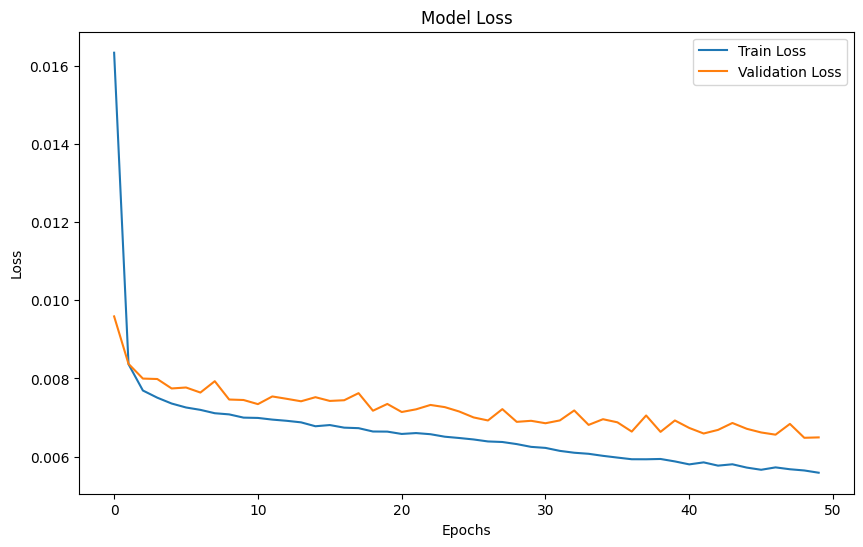

In [30]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib
import matplotlib.pyplot as plt

# 데이터 컬럼 선택
out_columns = [col for col in df.columns if 'out' in col]
inner_columns = [col for col in df.columns if 'inner' in col]

X = df[out_columns].values
y = df[inner_columns].values

# 데이터 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 스케일러 저장
joblib.dump(scaler_X, '/content/scaler_X.pkl')
joblib.dump(scaler_y, '/content/scaler_y.pkl')

# 윈도우 데이터 생성 함수
def create_windowed_data(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 6
X_windowed, y_windowed = create_windowed_data(X_scaled, y_scaled, window_size)
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(y_train.shape[1]))

# train 및 save model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))
model.save('/content/lstm_model.h5')


# loss 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 학습 결과 시각화

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


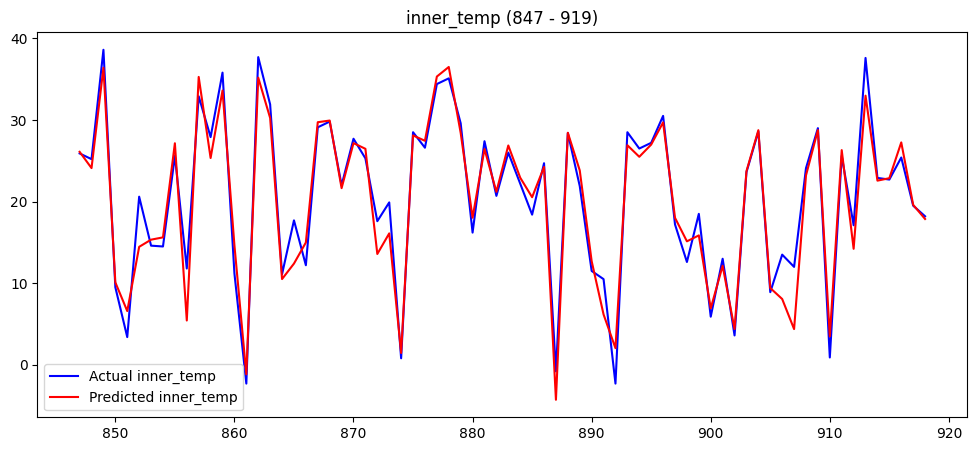

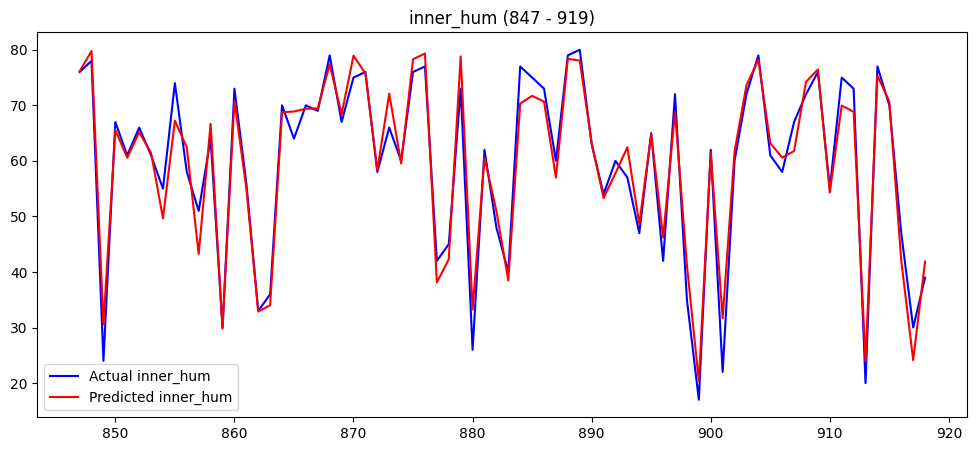

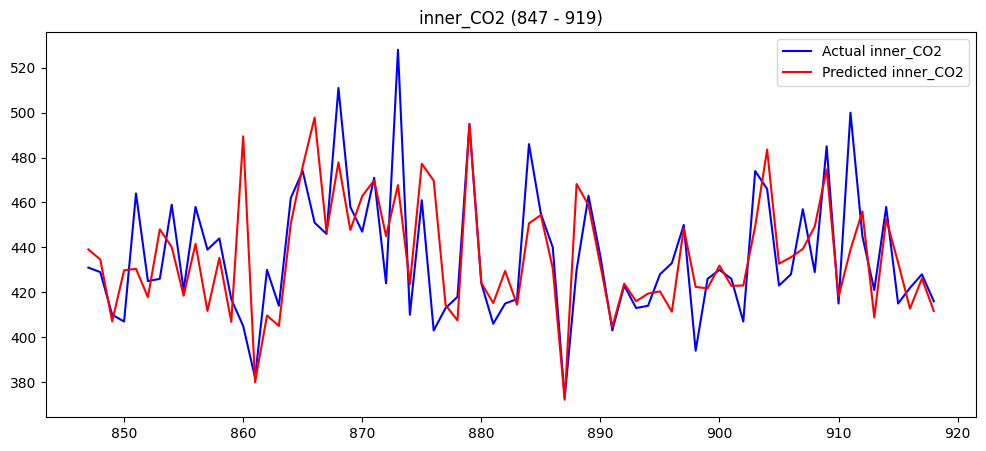

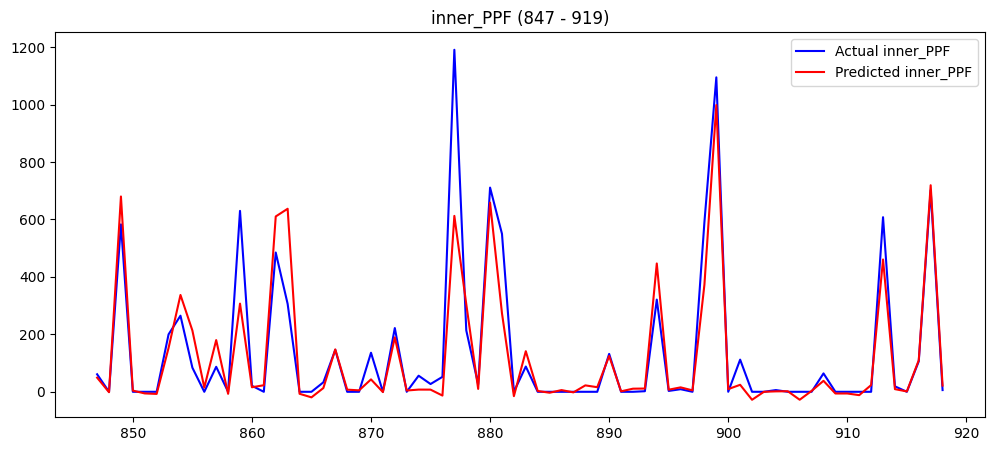

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual_unscaled = scaler_y.inverse_transform(y_test)

## 랜덤 샘플 추출 후 시각화
def plot_random_sample(y_test_actual, y_pred, inner_columns, sample_size):
    num_samples = y_test_actual.shape[0]
    start_index = np.random.randint(0, num_samples - sample_size)
    end_index = start_index + sample_size

    for i, column in enumerate(inner_columns):
        plt.figure(figsize=(12, 5))
        sns.lineplot(x=np.arange(start_index, end_index), y=y_test_actual[start_index:end_index, i], label=f'Actual {column}', color='blue')
        sns.lineplot(x=np.arange(start_index, end_index), y=y_pred[start_index:end_index, i], label=f'Predicted {column}', color='red')
        plt.title(f'{column} ({start_index} - {end_index})')
        plt.legend()
        plt.show()

plot_random_sample(y_test_actual_unscaled, y_pred, inner_columns, sample_size=72)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


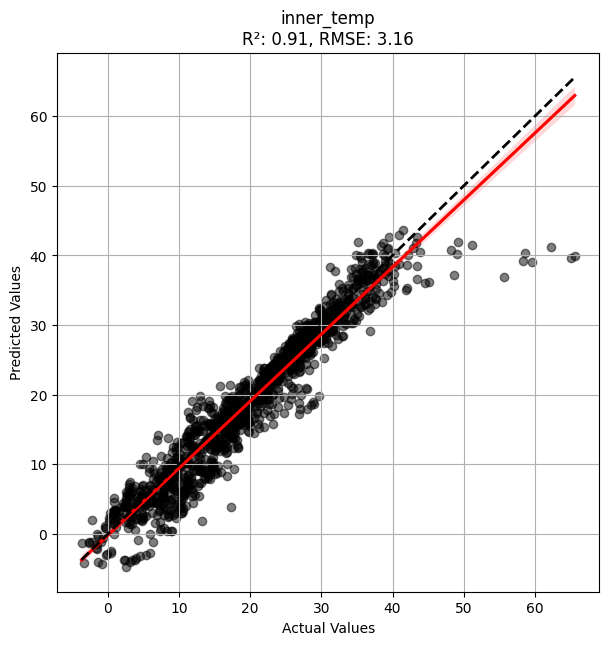

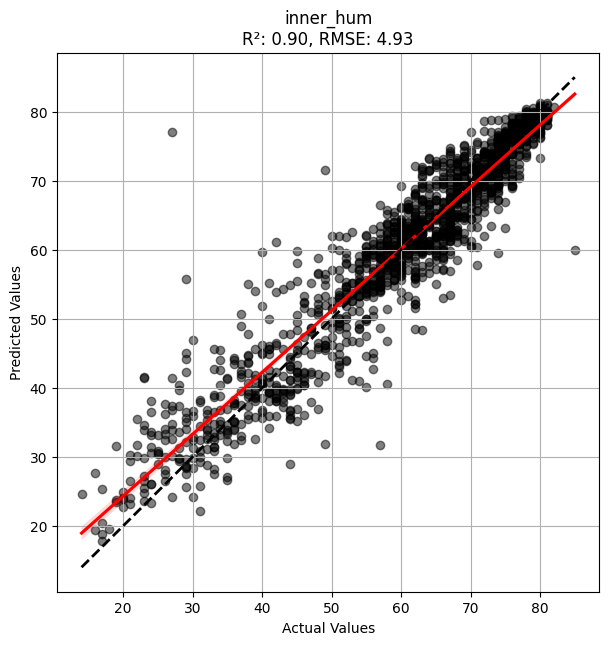

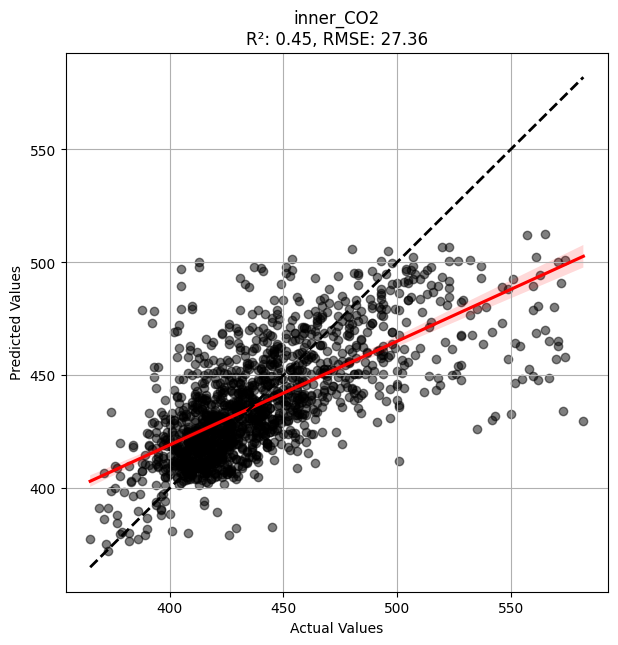

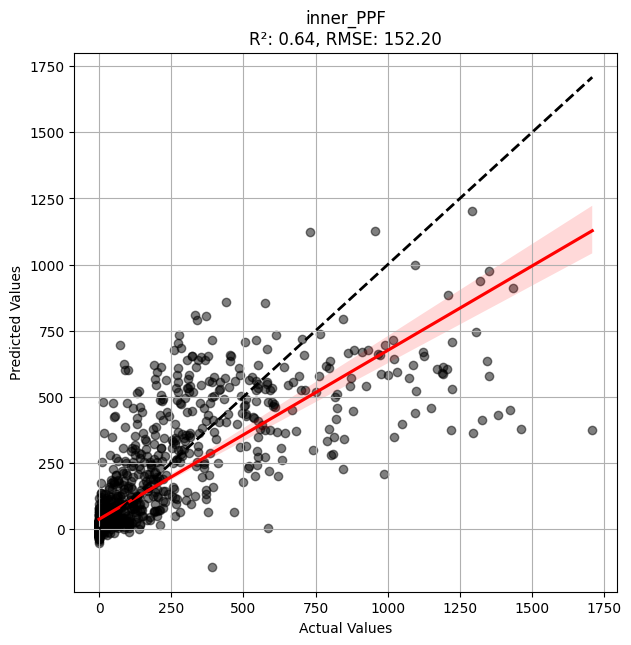

In [32]:
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual_unscaled = scaler_y.inverse_transform(y_test)

def plot_full_test_with_metrics(y_test_actual, y_pred, inner_columns, alpha=0.5):
    for i, column in enumerate(inner_columns):
        actual = y_test_actual[:, i]
        predicted = y_pred[:, i]

        r2 = r2_score(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))

        plt.figure(figsize=(7, 7))
        sns.regplot(x=actual, y=predicted, scatter_kws={'alpha': alpha, 'color': 'black'}, line_kws={'color': 'red'})
        plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2)
        plt.title(f'{column}\nR²: {r2:.2f}, RMSE: {rmse:.2f}')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.grid(True)
        plt.show()

plot_full_test_with_metrics(y_test_actual_unscaled, y_pred, inner_columns)


## 테스트 데이터를 이용한 모델 검증

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


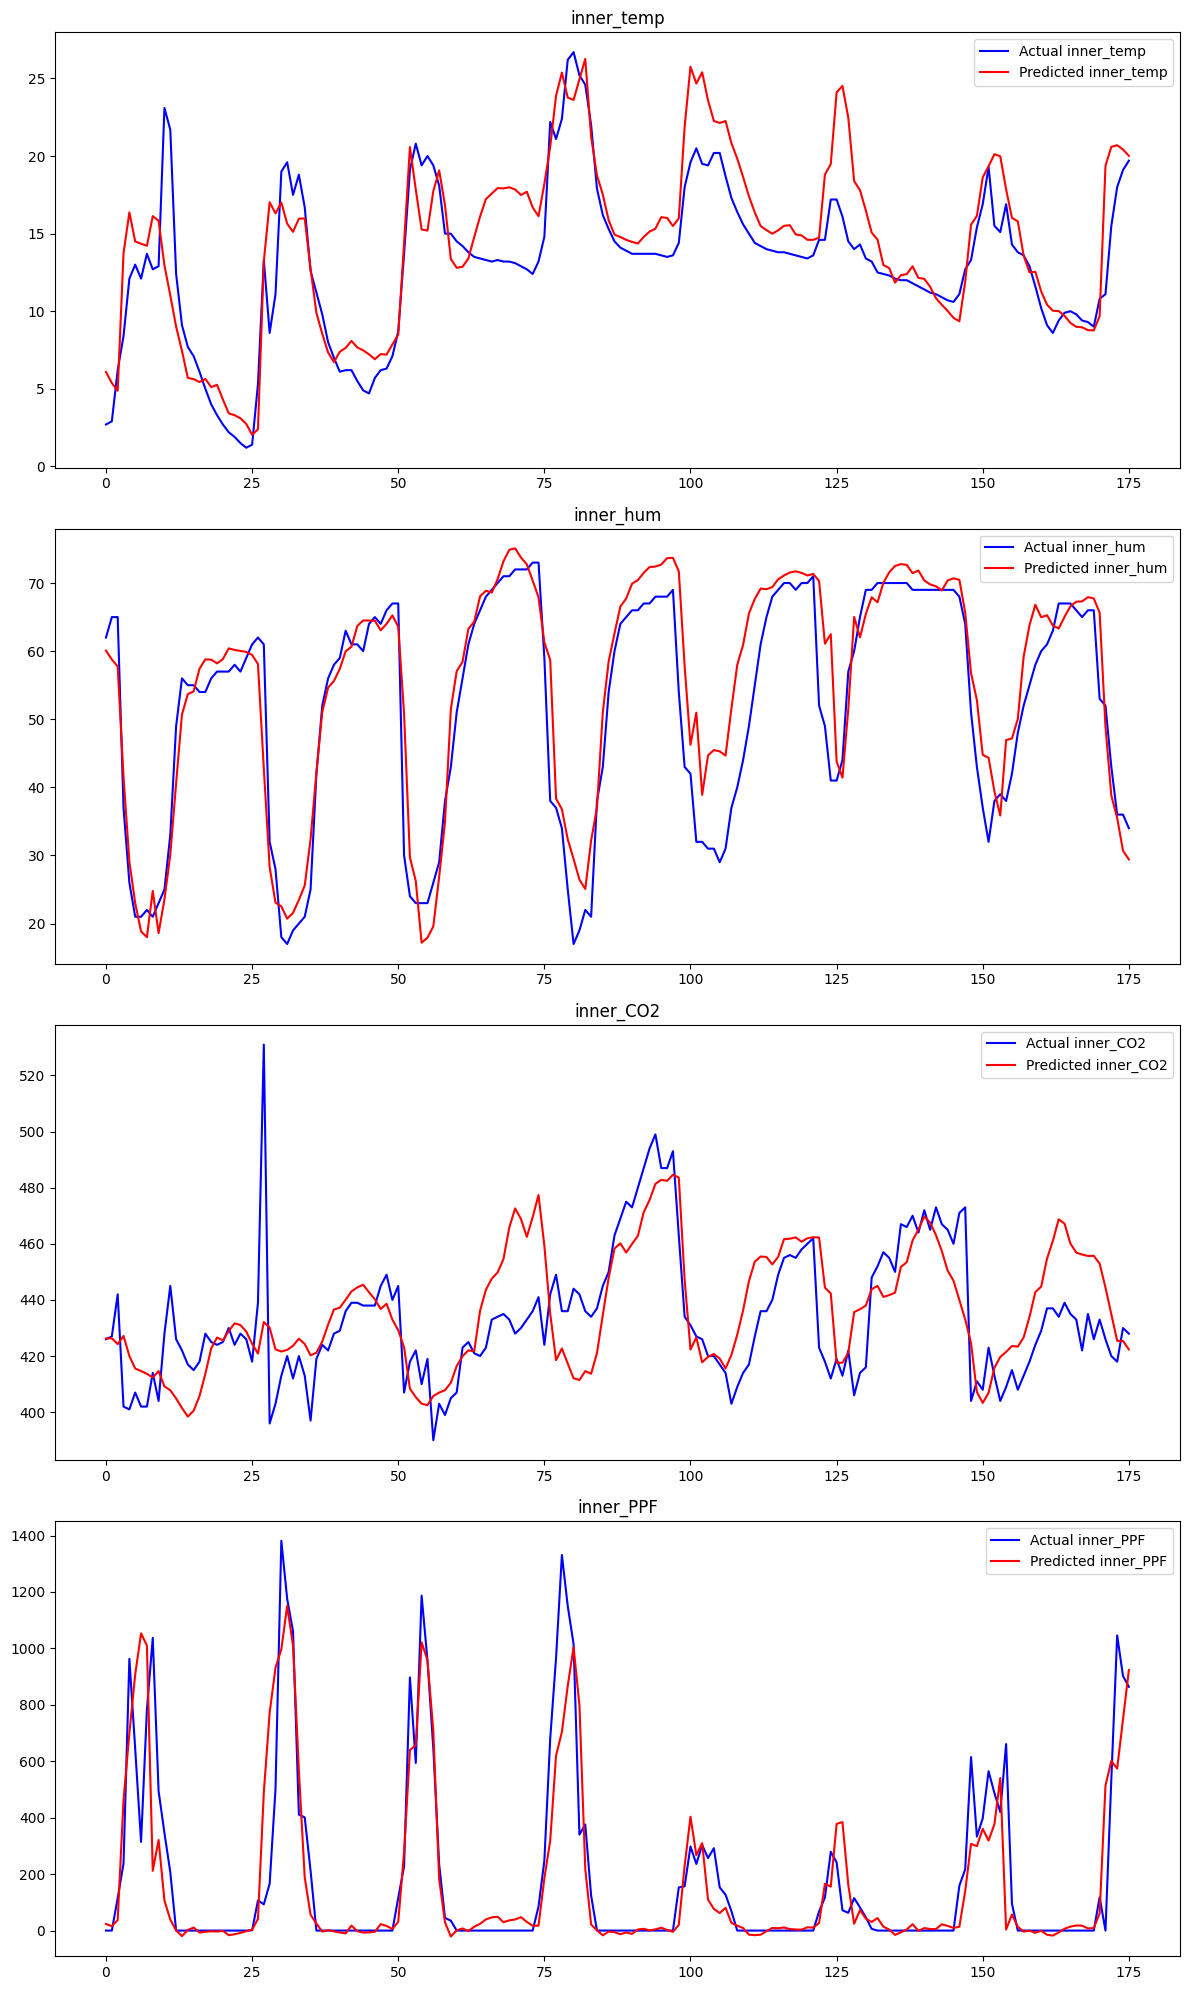

In [33]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 및 스케일러
model = load_model('/content/lstm_model.h5')
scaler_X = joblib.load('/content/scaler_X.pkl')
scaler_y = joblib.load('/content/scaler_y.pkl')

# 스케일링
out_columns = [col for col in test_df.columns if 'out' in col]
inner_columns = [col for col in test_df.columns if 'inner' in col]

X_test_new = test_df[out_columns].values
y_test_actual = test_df[inner_columns].values

X_test_new_scaled = scaler_X.transform(X_test_new)
y_test_actual_scaled = scaler_y.transform(y_test_actual)


def create_windowed_data_new(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 6
X_test_windowed, y_test_windowed = create_windowed_data_new(X_test_new_scaled, y_test_actual_scaled, window_size)

y_pred_scaled = model.predict(X_test_windowed)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_test_actual_unscaled = scaler_y.inverse_transform(y_test_windowed)
num_inner_columns = y_test_actual_unscaled.shape[1]

plt.figure(figsize=(12, 5 * num_inner_columns))
for i in range(num_inner_columns):
    plt.subplot(num_inner_columns, 1, i + 1)
    sns.lineplot(data=y_test_actual_unscaled[:, i], label=f'Actual {inner_columns[i]}', color='blue')
    sns.lineplot(data=y_pred[:, i], label=f'Predicted {inner_columns[i]}', color='red')
    plt.title(f'{inner_columns[i]}')
    plt.legend()

plt.tight_layout()
plt.show()


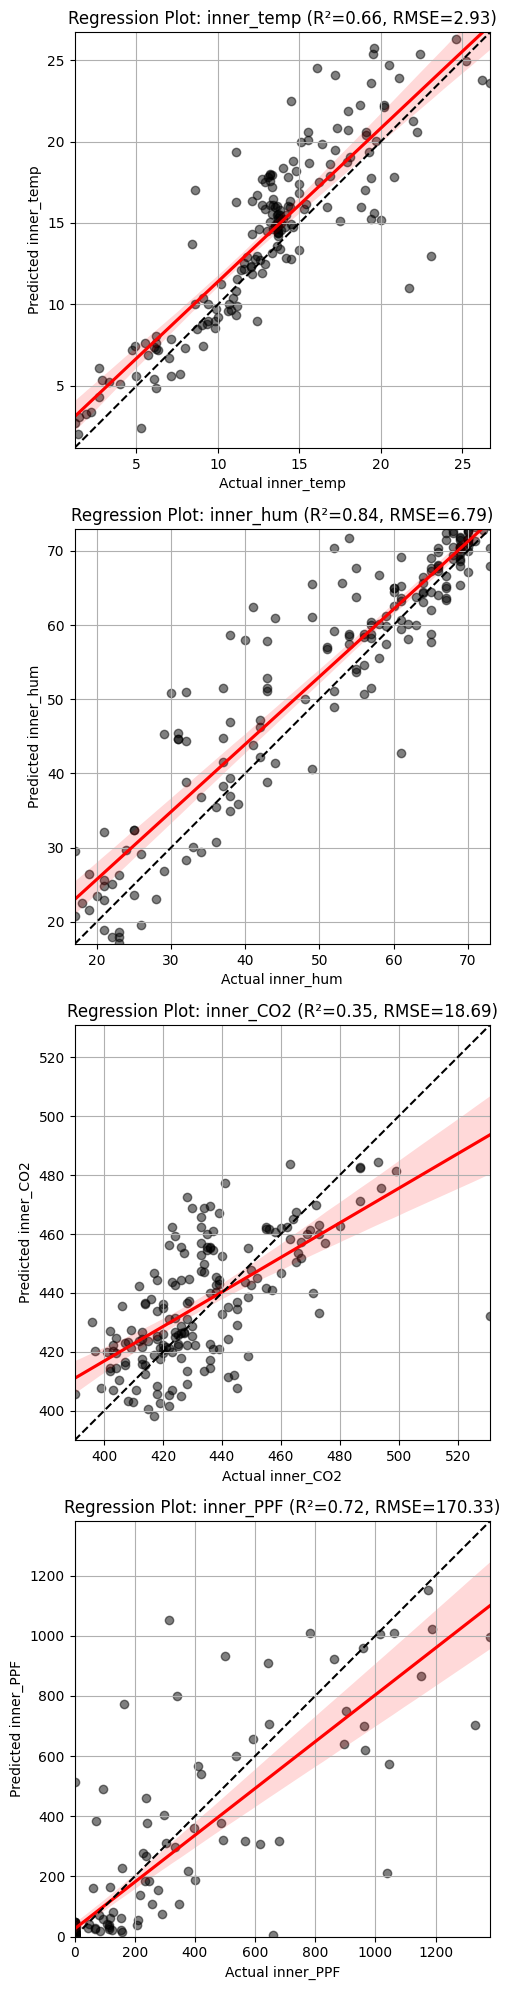

In [34]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

plt.figure(figsize=(5, 5 * num_inner_columns))

for i in range(num_inner_columns):
    plt.subplot(num_inner_columns, 1, i + 1)

    sns.regplot(
        x=y_test_actual_unscaled[:, i],
        y=y_pred[:, i],
        scatter_kws={'color': 'black', 'alpha': 0.5},
        line_kws={'color': 'red'}
    )

    r2 = r2_score(y_test_actual_unscaled[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_actual_unscaled[:, i], y_pred[:, i]))

    plt.title(f'Regression Plot: {inner_columns[i]} (R²={r2:.2f}, RMSE={rmse:.2f})')
    plt.xlabel(f'Actual {inner_columns[i]}')
    plt.ylabel(f'Predicted {inner_columns[i]}')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(min(y_test_actual_unscaled[:, i]), max(y_test_actual_unscaled[:, i]))
    plt.ylim(min(y_test_actual_unscaled[:, i]), max(y_test_actual_unscaled[:, i]))

    plt.plot([min(y_test_actual_unscaled[:, i]), max(y_test_actual_unscaled[:, i])],
             [min(y_test_actual_unscaled[:, i]), max(y_test_actual_unscaled[:, i])],
             linestyle='--', color='black')

    plt.grid(True)

plt.tight_layout()
plt.show()
